# Sequel of _downsampling_mwe.ipynb
Applying tests to all columns

In [1]:
import pandas as pd
# get the data
filepath = "data/2023_NCVR_Panse_1M/records.csv"
# filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                      keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,BD14354,tE4fUwczpZqxOPaF,ALICE,EAREHART,CROSTIC,1910,ND,CRAVEN,NEW BERN,28562,OLD AIRPORT,F,NL,W
1,A,BN88945,jJ0KwQLN2G2Ezr7U,ELAINE,VERA,CECELSKI,1956,CA,FORSYTH,WINSTON SALEM,27101,WESTDALE,F,NL,W
2,A,CW455506,VjT3l04cktpKK7cS,MATTHIAS,B,BERRANG,1972,NC,MECKLENBURG,CHARLOTTE,28210,CAMBORNE,M,NL,W
3,A,BN336378,vjfUr7VcG6pAEmb6,TIMOTHY,GRAY,CARTER,1957,NC,FORSYTH,RURAL HALL,27045,CHURCH,M,UN,W
4,A,AW217476,OJ0ZoJPZ3RIm3tOH,ROSALIE,CATHERINE,HUSVAR,1948,NY,CATAWBA,HICKORY,28601,22ND,F,NL,W


In [2]:
from scipy.stats import chisquare, entropy, spearmanr, anderson_ksamp
import matplotlib.pyplot as plt
from error_rates import get_all_errors

In [3]:
def scale_equally(e, o):
    e_scaled = e / e.sum()
    o_scaled = o / o.sum()
    return e_scaled, o_scaled

In [4]:
def visual_comparison(e, o, show_index, file_name):
    # e_scaled = e / float(sum(e)) * sum(o)
    e_scaled, o_scaled = scale_equally(e, o)
    print("### Visual Comparison (equally scaled) ###")
    print("Plot both")
    for s in [e_scaled, o_scaled]:
        plt.scatter(x=s.index if show_index else range(1, s.shape[0]+1), y=s.tolist(), s=2)  # s = marker size
    plt.legend(["e", "o"])
    plt.savefig(f"plots/downsampling/{file_name}-plot-both")
    plt.show()
    print("Plot total difference")
    diff = e_scaled.values - o_scaled.values
    plt.scatter(x=e.index if show_index else range(1, diff.shape[0]+1),
                y=diff, s=2)
    plt.savefig(f"plots/downsampling/{file_name}-diff")
    plt.show()
    # print(f"3. mean diff = {diff.mean()}")
    # print(f"4. std deviation of diff = {diff.std()} \n")
    # print(f"5. Plot rel-diff e to o")
    rel_diff = (e_scaled.values - o_scaled.values) / (e_scaled.values + o_scaled.values)
    plt.scatter(x=e.index if show_index else range(1, rel_diff.shape[0]+1),
                y=rel_diff, s=2)
    plt.savefig(f"plots/downsampling/{file_name}-reldiff")
    plt.show()
    # print(f"6. mean rel-diff = {rel_diff.mean()}")
    # print(f"7. std deviation of rel-diff = {rel_diff.std()} \n")
    return diff, rel_diff

def chi(e, o):
    # print("### Chi Square GOF ###")
    # print("(requires equal scaling)")
    e_scaled, o_scaled = scale_equally(e, o)
    p = chisquare(o_scaled, e_scaled)[1]
    # print(f"p = {p}")
    # print("different" if p < 0.05 else "same")
    # print("\n")
    return p

def KLD(e, o):
    # print("### Kullback Leibler Divergence ###")
    # print("(does not depend on scaling)")
    res = entropy(e, o, 2)
    # print(f"D = {res} \n")
    return res

def RCC(e, o):
    # print("### Rank Correlation Coefficient ###")
    # print("(does not depend on scaling, only order)")
    res = spearmanr(e, o)
    # print(res)
    # print("same" if res.pvalue < 0.05 else "different")
    # print("\n")
    return res

def kAD(e, o):
    print("### Anderson Darling Test ###")
    print("(does not depend on order, only on scaling)")
    e_scaled, o_scaled = scale_equally(e, o)
    res = anderson_ksamp([e_scaled, o_scaled])
    print(res)
    print("different" if res.statistic > res.critical_values[2] else "same")
    print("\n")
    return res

def make_all_tests(e, o, file_name):
    # filter the categories that are not in both datasets
    e = e[e.index.isin(o.index)]
    o = o[o.index.isin(e.index)]
    assert e.sort_index().index.equals(o.sort_index().index)
    print(f"shapes after filter={e.shape}")
    print("--- Sort by value ---")
    e = e.sort_values(ascending=False)
    o = o.sort_values(ascending=False)
    visual_comparison(e, o, show_index=False, file_name="sort-index/"+file_name)
    chi(e, o)
    KLD(e, o)
    RCC(e, o)
    # kAD(e, o)
    print("--- Sort by Index ---")
    e = e.sort_index(ascending=False)
    o = o.sort_index(ascending=False)
    visual_comparison(e, o, show_index=e.index.shape[0]<200, file_name="sort-value/"+file_name)
    chi(e, o)
    KLD(e, o)
    RCC(e, o)
    # kAD(e, o)

def make_all_tests(df_base, df_res, columns, sort: str):
    print(f"\n --- Sort by {sort} ---")
    result_1 = {"column": [], "mean diff": [], "mean var of diff": [], "mean rel diff": [], "mean var of rel diff": []}
    result_2 = {"column": [], "chi": [], "kld": [], "rcc_co": [], "rcc_p": []}
    err_measure = "count_errors"
    all_errors_base = get_all_errors(df_base, err_measure)
    all_errors_res = get_all_errors(df_res, err_measure)
    data = [((df_base[col].value_counts(), df_res[col].value_counts()), col) for col in columns] + \
           [((all_errors_base, all_errors_res), "ERROR-RATE"),
                                   ((all_errors_base.value_counts(), all_errors_res.value_counts()), "ERROR-RATE-DIST")]
    for (e, o), col in data:
        e = e[e.index.isin(o.index)]
        o = o[o.index.isin(e.index)]
        print(f"### {col} ###")
        if sort == "value":
            e = e.sort_values(ascending=False)
            o = o.sort_values(ascending=False)
        elif sort == "index":
            e = e.sort_index(ascending=False)
            o = o.sort_index(ascending=False)
        else:
            raise ValueError(sort)
        diff, rel_diff = visual_comparison(e, o, show_index=False if sort=="value" else e.index.shape[0]<200, file_name=f"sort-{sort}/" + col)
        chi_p = chi(e, o)
        kld_res = KLD(e, o)
        rcc_res = RCC(e, o)
        result_1["column"].append(col)
        result_1["mean diff"].append(diff.mean())
        result_1["mean var of diff"].append(diff.var())
        result_1["mean rel diff"].append(rel_diff.mean())
        result_1["mean var of rel diff"].append(rel_diff.var())
        result_2["column"].append(col)
        result_2["chi"].append(chi_p)
        result_2["kld"].append(kld_res)
        result_2["rcc_co"].append(rcc_res.correlation)
        result_2["rcc_p"].append(rcc_res.pvalue)
    return pd.DataFrame.from_dict(result_1), pd.DataFrame.from_dict(result_2)

In [5]:
from random_sample import random_sample_wrapper
from dataset_properties import split_and_get_overlap

sample_size = 200_000

# df_res1 = random_sample_wrapper(df, sample_size, seed=42)
# df_res1 = df.sample(sample_size, random_state=42)
df_res1 = df

In [6]:
overlap = split_and_get_overlap(df_res1)
overlap

0.2

In [7]:
df_res2 = random_sample_wrapper(df, sample_size, overlap=overlap, seed=43)

In [8]:
cols = ["FIRSTNAME", "GENDER", "YEAROFBIRTH", "PLACEOFBIRTH", "RACE"]

### Sort by Value


 --- Sort by value ---
### FIRSTNAME ###
### Visual Comparison (equally scaled) ###
Plot both


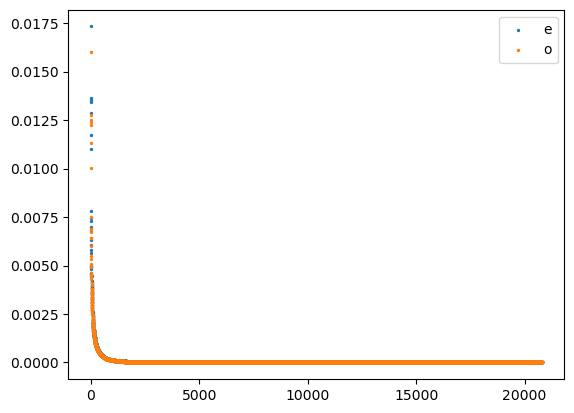

Plot total difference


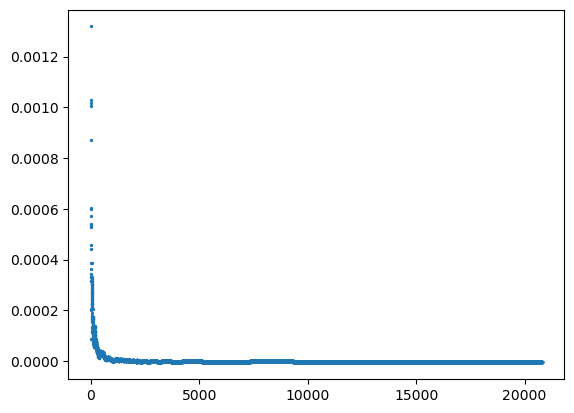

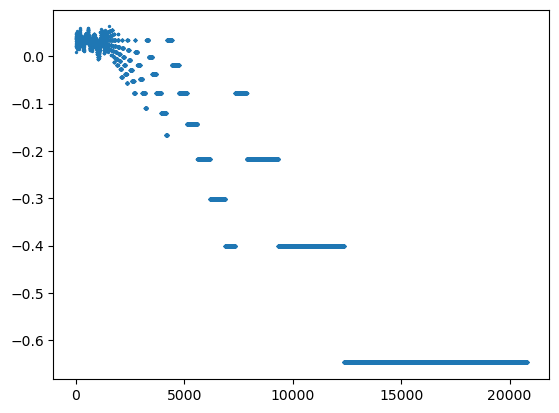

### GENDER ###
### Visual Comparison (equally scaled) ###
Plot both


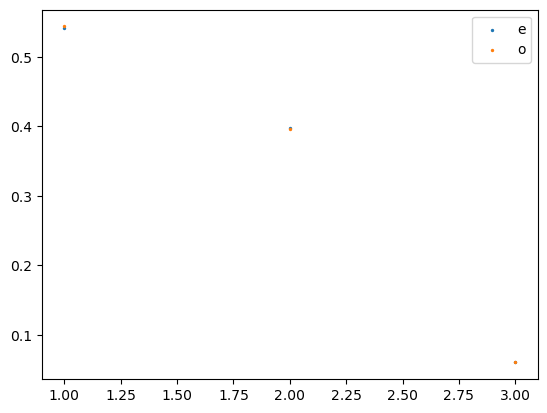

Plot total difference


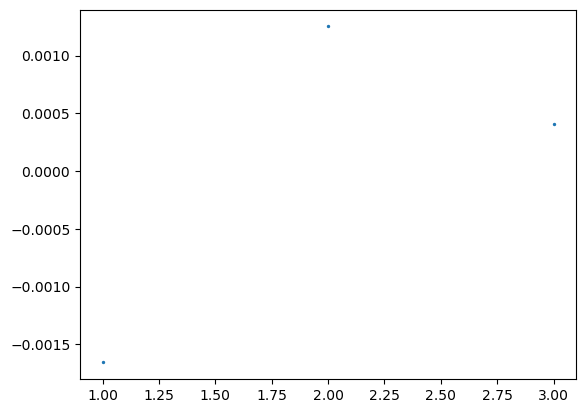

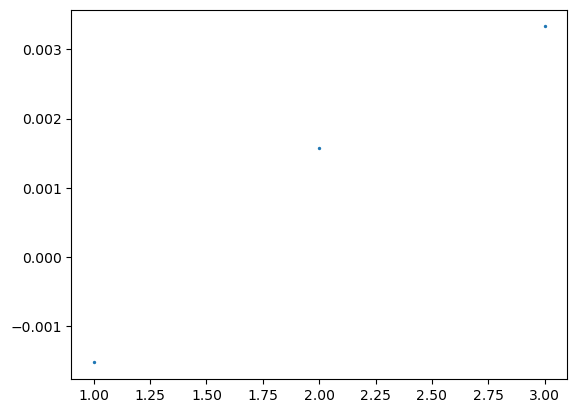

### YEAROFBIRTH ###
### Visual Comparison (equally scaled) ###
Plot both


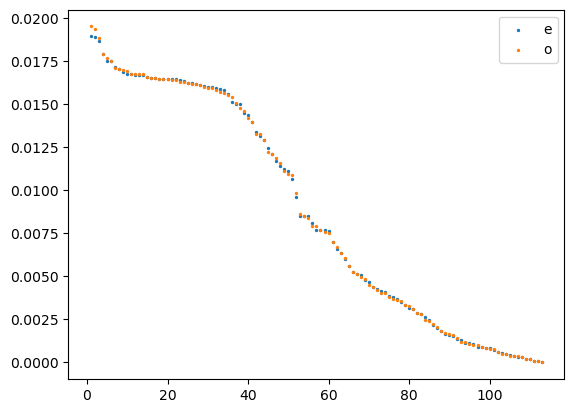

Plot total difference


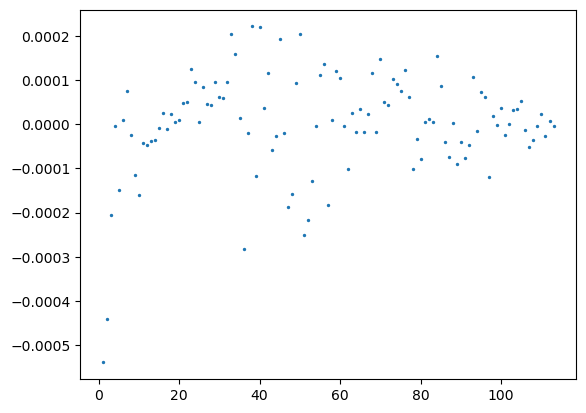

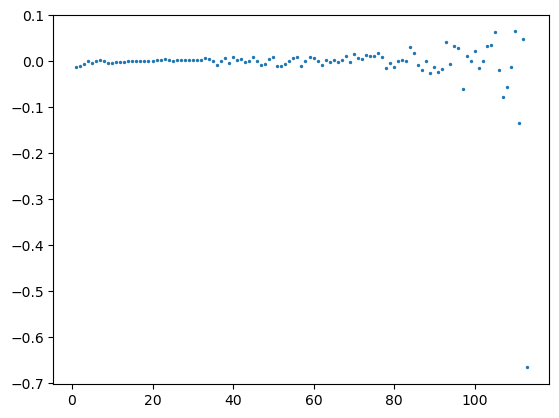

### PLACEOFBIRTH ###
### Visual Comparison (equally scaled) ###
Plot both


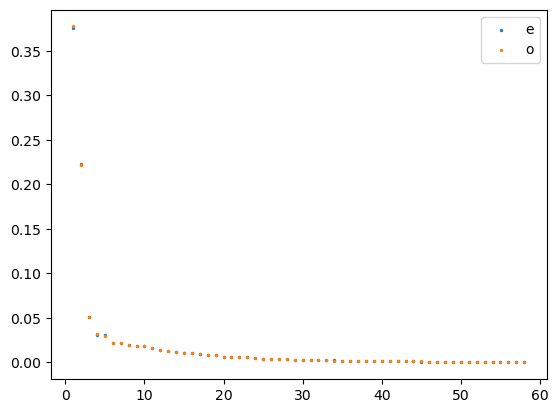

Plot total difference


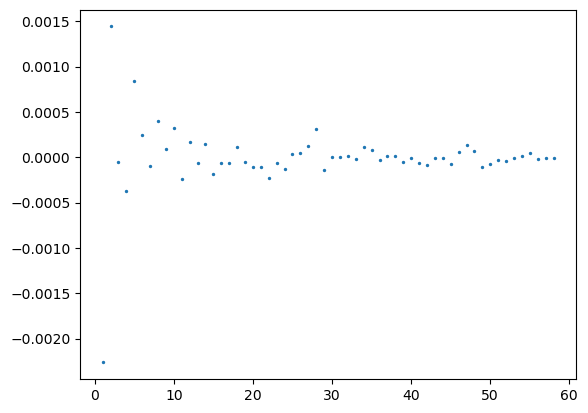

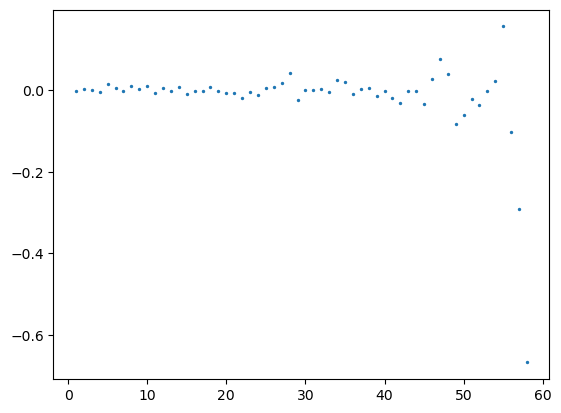

### RACE ###
### Visual Comparison (equally scaled) ###
Plot both


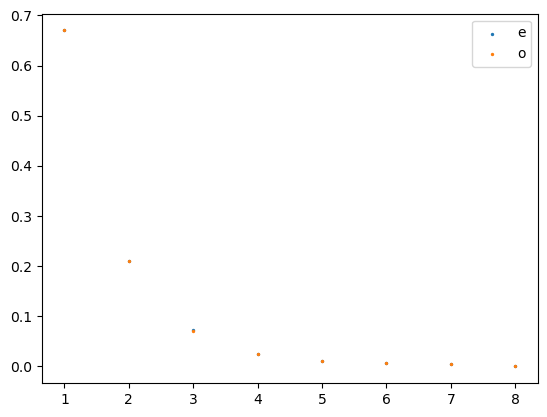

Plot total difference


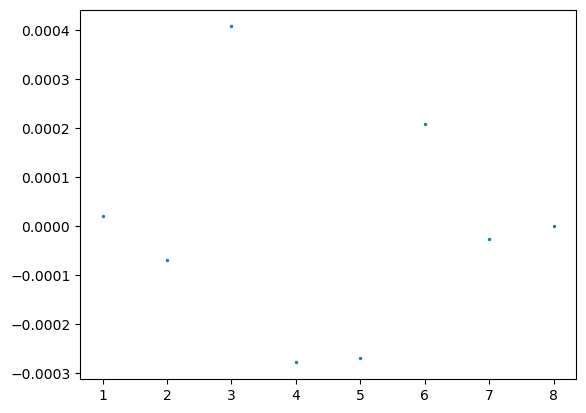

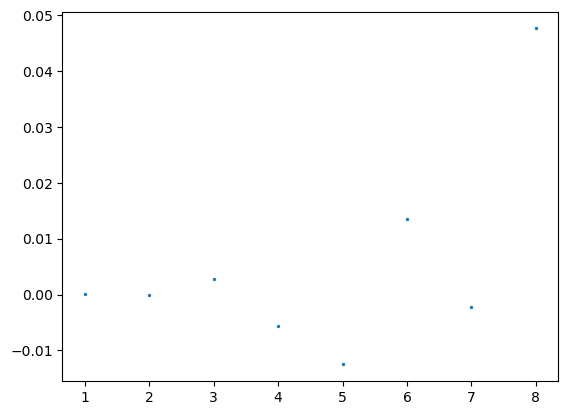

### ERROR-RATE ###
### Visual Comparison (equally scaled) ###
Plot both


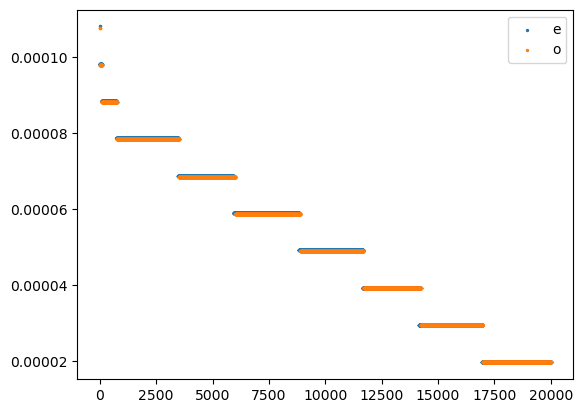

Plot total difference


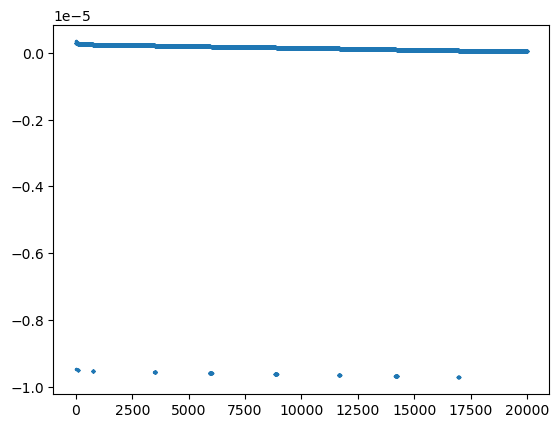

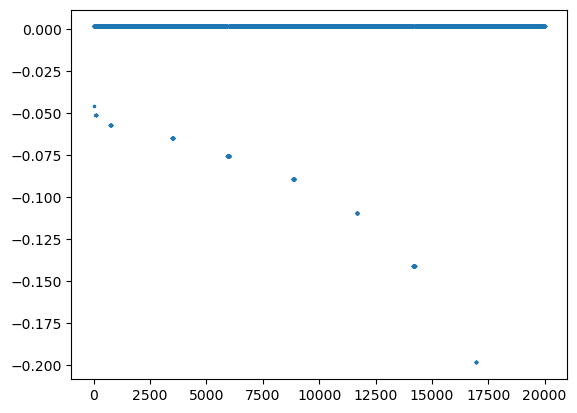

### ERROR-RATE-DIST ###
### Visual Comparison (equally scaled) ###
Plot both


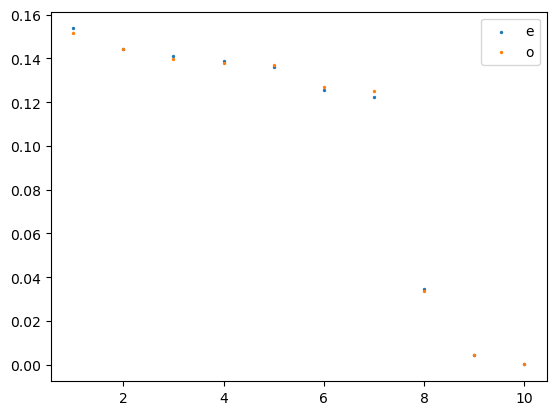

Plot total difference


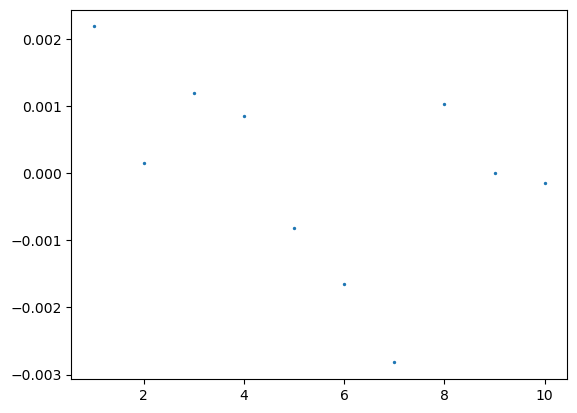

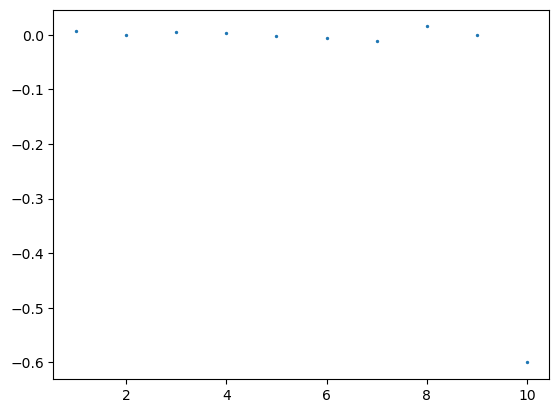

In [9]:
res = make_all_tests(df_res1, df_res2, cols, sort="value")

In [10]:
res[0]

,column,mean diff,mean var of diff,mean rel diff,mean var of rel diff
0,FIRSTNAME,-1.668164e-22,6.673058e-10,-0.369967,0.069101
1,GENDER,3.932040e-17,1.492393e-06,0.001128,0.000004
2,YEAROFBIRTH,-6.566379e-21,1.350832e-08,-0.005986,0.004388
3,PLACEOFBIRTH,-2.824709e-19,1.531719e-07,-0.017178,0.009918
4,RACE,-6.955835e-18,4.564050e-08,0.005407,0.000302
5,ERROR-RATE,1.759796e-21,1.548560e-12,0.000003,0.000175
6,ERROR-RATE-DIST,-1.653408e-18,1.943560e-06,-0.059059,0.032562


In [11]:
res[1]

,column,chi,kld,rcc_co,rcc_p
0,FIRSTNAME,1.000000,0.040174,0.881761,0.000000e+00
1,GENDER,0.999994,0.000008,1.000000,0.000000e+00
2,YEAROFBIRTH,1.000000,0.000158,0.999994,5.131614e-274
3,PLACEOFBIRTH,1.000000,0.000180,0.999985,4.895676e-128
4,RACE,1.000000,0.000013,1.000000,0.000000e+00
5,ERROR-RATE,1.000000,0.000432,0.998343,0.000000e+00
6,ERROR-RATE-DIST,1.000000,0.000239,1.000000,6.646897e-64


In [12]:
res[0].to_csv("plots/downsampling/sort-value-diff.csv", float_format='%.5f', index=False)
res[1].to_csv("plots/downsampling/sort-value-tests.csv", float_format='%.5f', index=False)

### Sort by Index


 --- Sort by index ---
### FIRSTNAME ###
### Visual Comparison (equally scaled) ###
Plot both


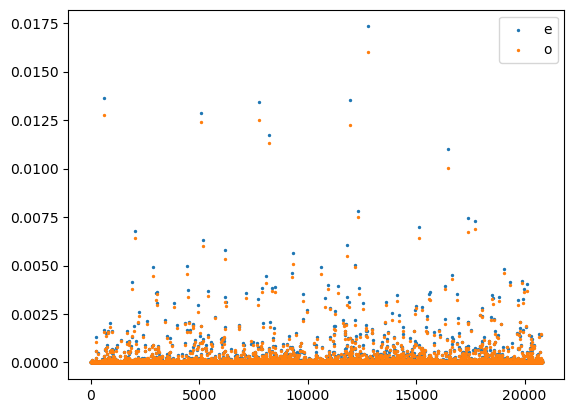

Plot total difference


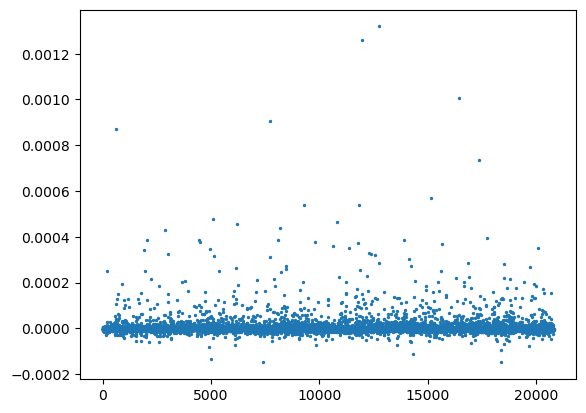

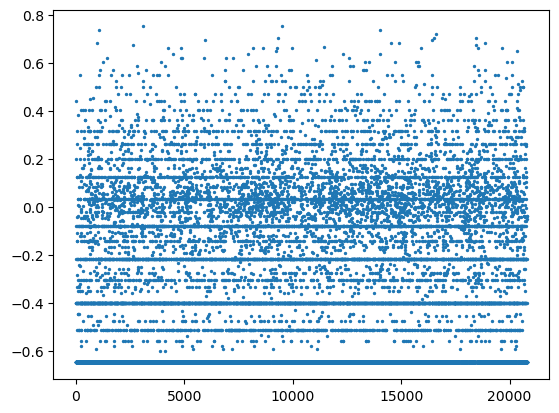

### GENDER ###
### Visual Comparison (equally scaled) ###
Plot both


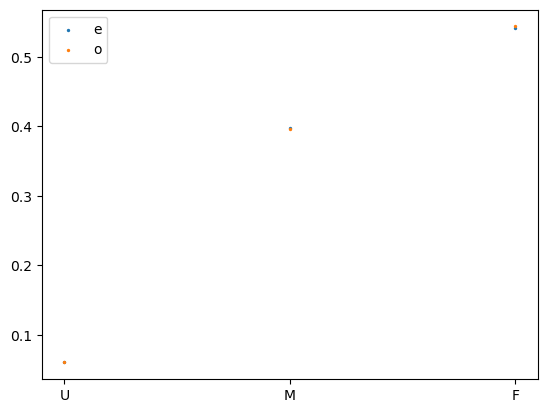

Plot total difference


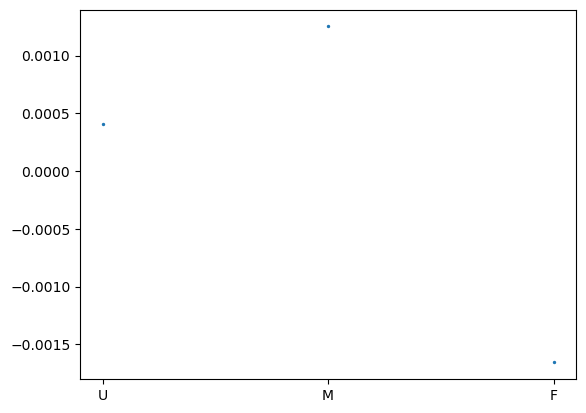

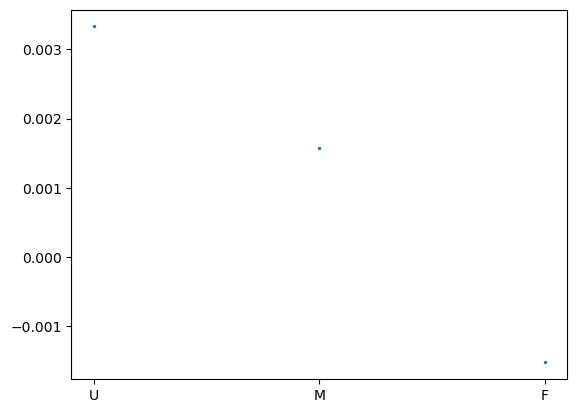

### YEAROFBIRTH ###
### Visual Comparison (equally scaled) ###
Plot both


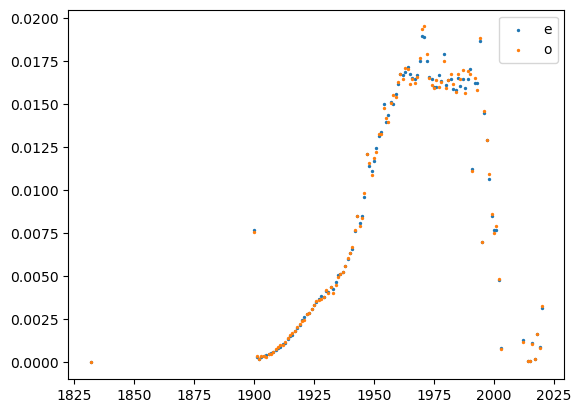

Plot total difference


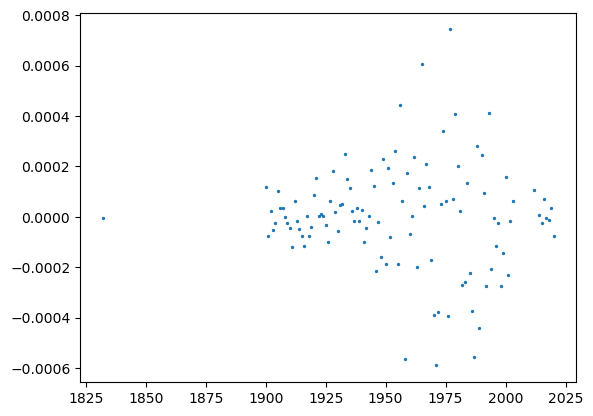

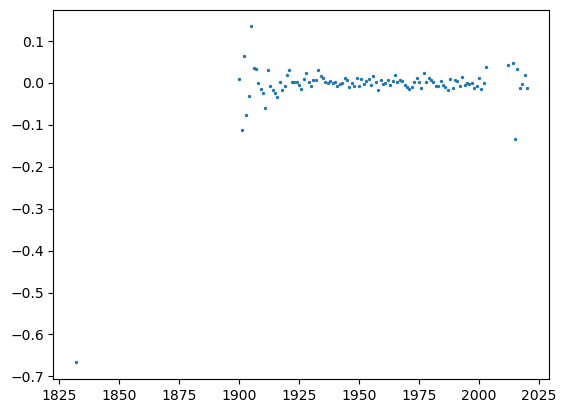

### PLACEOFBIRTH ###
### Visual Comparison (equally scaled) ###
Plot both


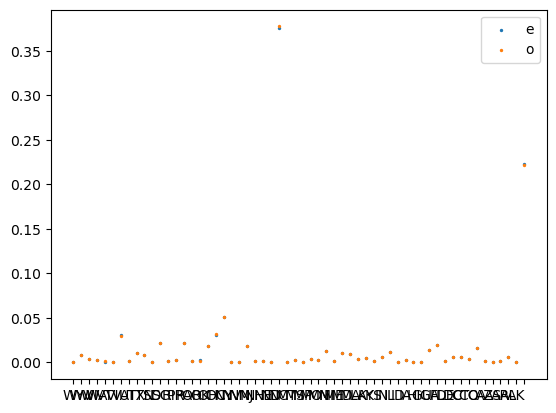

Plot total difference


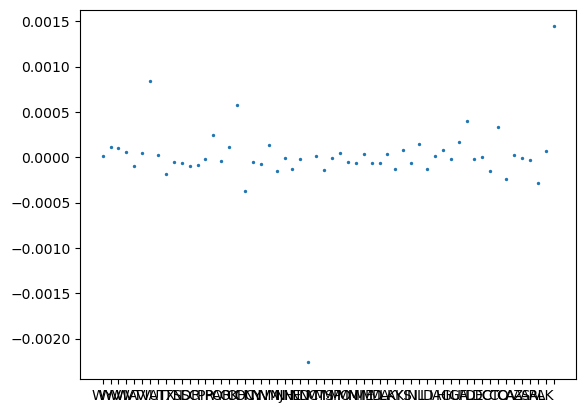

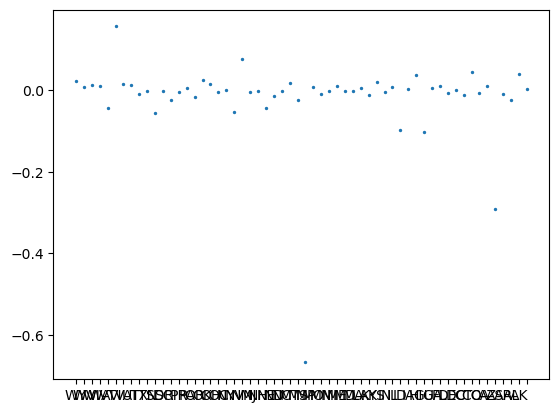

### RACE ###
### Visual Comparison (equally scaled) ###
Plot both


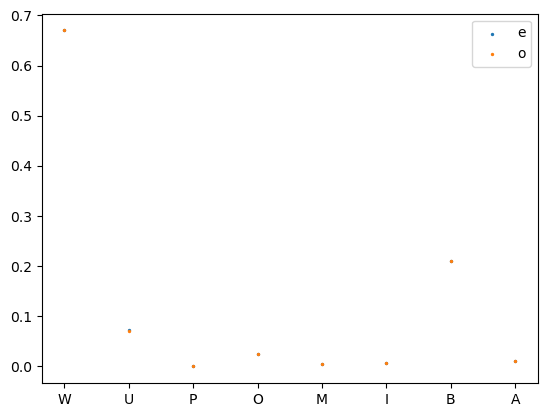

Plot total difference


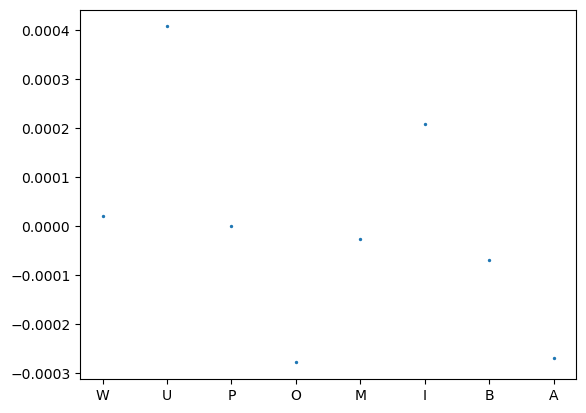

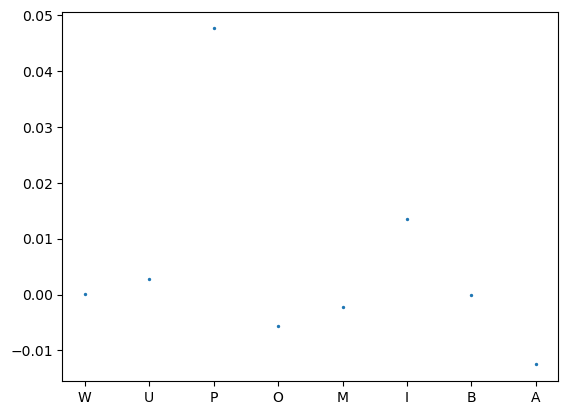

### ERROR-RATE ###
### Visual Comparison (equally scaled) ###
Plot both


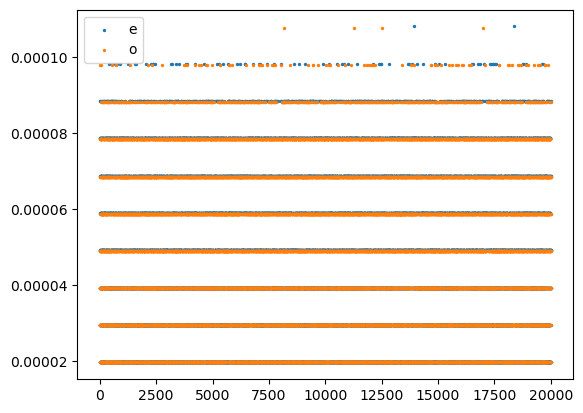

Plot total difference


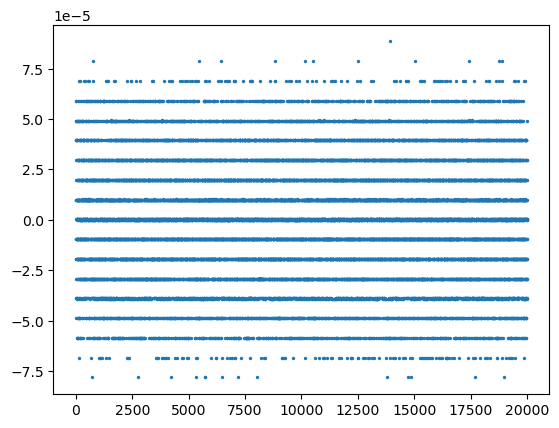

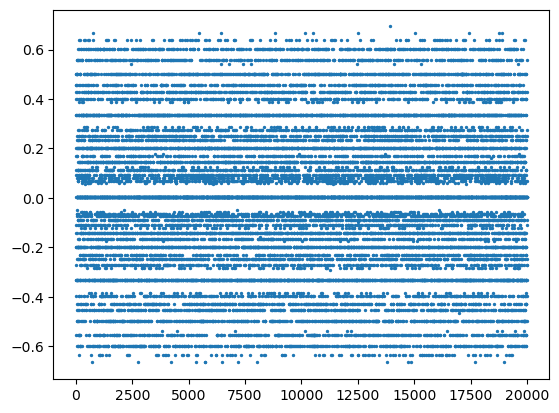

### ERROR-RATE-DIST ###
### Visual Comparison (equally scaled) ###
Plot both


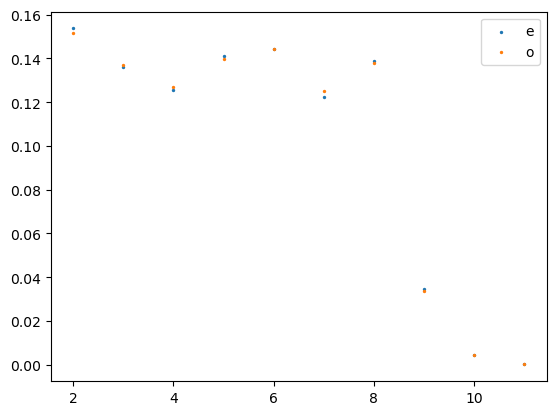

Plot total difference


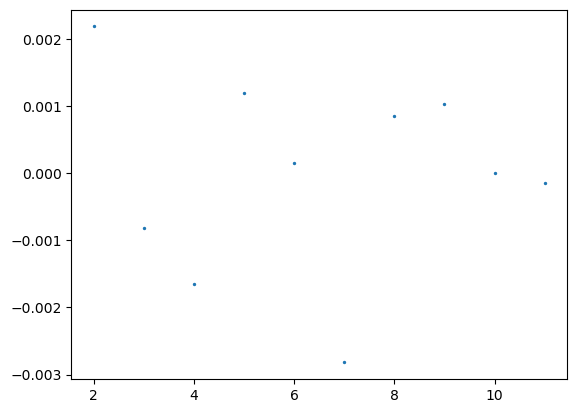

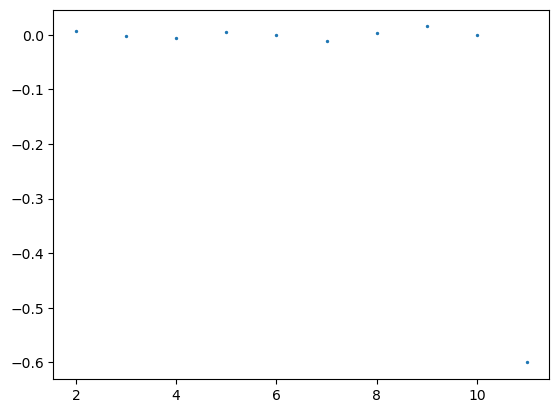

(            column     mean diff  mean var of diff  mean rel diff  \
 0        FIRSTNAME -6.412004e-22      8.230865e-10      -0.363817   
 1           GENDER  3.932040e-17      1.492393e-06       0.001128   
 2      YEAROFBIRTH -5.606908e-21      4.399470e-08      -0.005988   
 3     PLACEOFBIRTH -2.766585e-19      1.584995e-07      -0.017175   
 4             RACE -6.952446e-18      4.564050e-08       0.005407   
 5       ERROR-RATE  1.485357e-21      8.739855e-10       0.000052   
 6  ERROR-RATE-DIST -1.647987e-18      1.943560e-06      -0.059059   
 
    mean var of rel diff  
 0              0.103878  
 1              0.000004  
 2              0.004659  
 3              0.010043  
 4              0.000302  
 5              0.095255  
 6              0.032562  ,
             column       chi       kld    rcc_co          rcc_p
 0        FIRSTNAME  1.000000  0.065216  0.769587   0.000000e+00
 1           GENDER  0.999994  0.000008  1.000000   0.000000e+00
 2      YEAROFBIRTH  1.000

In [13]:
make_all_tests(df_res1, df_res2, cols, sort="index")

In [14]:
res[0]

,column,mean diff,mean var of diff,mean rel diff,mean var of rel diff
0,FIRSTNAME,-1.668164e-22,6.673058e-10,-0.369967,0.069101
1,GENDER,3.932040e-17,1.492393e-06,0.001128,0.000004
2,YEAROFBIRTH,-6.566379e-21,1.350832e-08,-0.005986,0.004388
3,PLACEOFBIRTH,-2.824709e-19,1.531719e-07,-0.017178,0.009918
4,RACE,-6.955835e-18,4.564050e-08,0.005407,0.000302
5,ERROR-RATE,1.759796e-21,1.548560e-12,0.000003,0.000175
6,ERROR-RATE-DIST,-1.653408e-18,1.943560e-06,-0.059059,0.032562


In [15]:
res[1]

,column,chi,kld,rcc_co,rcc_p
0,FIRSTNAME,1.000000,0.040174,0.881761,0.000000e+00
1,GENDER,0.999994,0.000008,1.000000,0.000000e+00
2,YEAROFBIRTH,1.000000,0.000158,0.999994,5.131614e-274
3,PLACEOFBIRTH,1.000000,0.000180,0.999985,4.895676e-128
4,RACE,1.000000,0.000013,1.000000,0.000000e+00
5,ERROR-RATE,1.000000,0.000432,0.998343,0.000000e+00
6,ERROR-RATE-DIST,1.000000,0.000239,1.000000,6.646897e-64


In [16]:
res[0].to_csv("plots/downsampling/sort-index-diff.csv", float_format='%.5f', index=False)
res[1].to_csv("plots/downsampling/sort-index-tests.csv", float_format='%.5f', index=False)

Note: Sort by index not  meaningful with this error rate data
But we could do it with an error rate frequency distribution: